In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf 
import random as rnd
import visualkeras as vk
import pydot as pyd
from PIL import Image
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator 
from keras.layers import Conv2D,MaxPooling2D,AveragePooling2D,Dense,Flatten,Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix,classification_report

Preparing the DataGenerators

In [2]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
)
test_datagen = ImageDataGenerator(rescale=1./255)

Processing the Training Set

In [3]:
training_set = train_datagen.flow_from_directory(
    'Plants/train',
    target_size=(64,64),
    batch_size=32,
    class_mode='categorical'
)

Found 140557 images belonging to 38 classes.


Processing the Test Set

In [4]:
evaluation_set = test_datagen.flow_from_directory(
    'Plants/valid',
    target_size=(64,64),
    batch_size=32,
    class_mode='categorical'
)

Found 35144 images belonging to 38 classes.


In [5]:
categories = 38

Building the CNN

In [6]:
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=32,kernel_size=(4,4),activation='relu',input_shape=[64,64,3],name='Conv2D-1'))
cnn_model.add(Conv2D(filters=32,kernel_size=(4,4),activation='relu',name='Conv2D-2'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Dropout(0.3))
cnn_model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',name='Conv2D-3'))
cnn_model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',name='Conv2D-4'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Dropout(0.2))
cnn_model.add(Flatten())
cnn_model.add(Dense(units=512,activation='relu',name='Dense-1'))
cnn_model.add(Dense(units=512,activation='relu',name='Dense-2'))
cnn_model.add(Dense(units=38,activation='softmax',name='Output'))

Visulaization of the Network

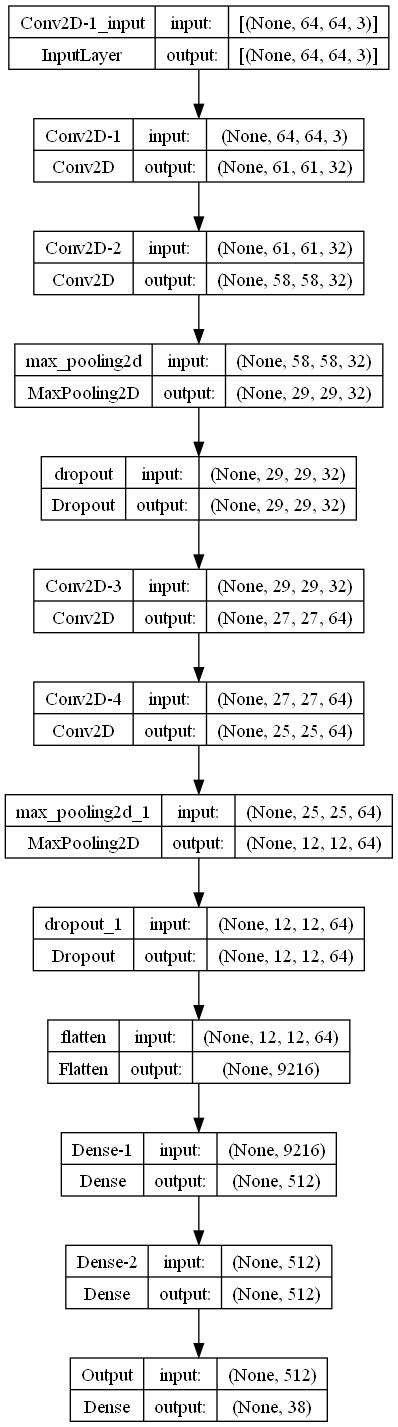

In [7]:
img = vk.layered_view(cnn_model)
if img.mode == 'RGBA':
    img = img.convert('RGB')
img.save('model_visualization.jpg')
plot_model(cnn_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [8]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D-1 (Conv2D)           (None, 61, 61, 32)        1568      
                                                                 
 Conv2D-2 (Conv2D)           (None, 58, 58, 32)        16416     
                                                                 
 max_pooling2d (MaxPooling2  (None, 29, 29, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 29, 29, 32)        0         
                                                                 
 Conv2D-3 (Conv2D)           (None, 27, 27, 64)        18496     
                                                                 
 Conv2D-4 (Conv2D)           (None, 25, 25, 64)        36928     
                                                        

Compiling The Model

In [9]:
cnn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) ,loss ='categorical_crossentropy' ,metrics = ['accuracy'],)

Training the CNN on Training Set and Evaluation Set 

In [10]:
history = cnn_model.fit(x = training_set,validation_data=evaluation_set,epochs=10,workers=10)

Epoch 1/10


4393/4393 [==============================] - 825s 187ms/step - loss: 1.4087 - accuracy: 0.5786 - val_loss: 1.4771 - val_accuracy: 0.5915
Epoch 2/10
4393/4393 [==============================] - 797s 181ms/step - loss: 0.6776 - accuracy: 0.7817 - val_loss: 1.1501 - val_accuracy: 0.6728
Epoch 3/10
4393/4393 [==============================] - 726s 165ms/step - loss: 0.4946 - accuracy: 0.8382 - val_loss: 0.8263 - val_accuracy: 0.7597
Epoch 4/10
4393/4393 [==============================] - 686s 156ms/step - loss: 0.3880 - accuracy: 0.8720 - val_loss: 0.7008 - val_accuracy: 0.7870
Epoch 5/10
4393/4393 [==============================] - 692s 158ms/step - loss: 0.3197 - accuracy: 0.8932 - val_loss: 0.8571 - val_accuracy: 0.7600
Epoch 6/10
4393/4393 [==============================] - 708s 161ms/step - loss: 0.2664 - accuracy: 0.9114 - val_loss: 0.6160 - val_accuracy: 0.8176
Epoch 7/10
4393/4393 [==============================] - 696s 158ms/step - loss: 0.2298 - accuracy: 0.9220 - va

Making Single Prediction

In [11]:
from keras.preprocessing import image 
test_image = image.load_img('testImg/TomatoYellowCurlVirus1.jpg',target_size=(64,64))#converted jpg into PIL format
test_image = image.img_to_array(test_image)
test_image  = np.expand_dims(test_image,axis=0)
x =test_image.shape
result = cnn_model.predict(test_image/255.0)
prediction = np.argmax(result)

1/1 [==============================] - 0s 133ms/step


In [12]:
class_labels = training_set.class_indices.keys()
labels = []
for key in class_labels:
    labels.append(key)

In [13]:
print(labels[prediction])

Tomato___Tomato_Yellow_Leaf_Curl_Virus


Making prediction for all the Test Images

In [14]:
import os
from PIL import Image
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".JPG") :  # Add other image formats if needed
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path)
            img = img.resize((64,64))
            img_array = np.array(img)
            img_array = np.expand_dims(img_array,axis=0)
            # x = img_array.shape
            # print(x)
            images.append(img_array)
    return images

image_folder = 'testImg'  
image_list = load_images_from_folder(image_folder)
_array = np.array(image_list)
print(f'Loaded {len(image_list)} images.')


Loaded 33 images.


In [15]:
prediction_classes = []
for image in image_list:
    result = np.argmax(cnn_model.predict(image/255.0))
    prediction_classes.append(result)

1/1 [==============================] - 0s 30ms/step


In [16]:
test_classes = [2,2,2,2,0,0,0,8,8,8,20,20,20,20,20,22,22,29,29,29,29,29,29,37,37,37,37,35,35,35,35,35,35]

In [17]:
accuracy = accuracy_score(test_classes, prediction_classes)
precision = precision_score(test_classes, prediction_classes, average='weighted')
recall = recall_score(test_classes, prediction_classes, average='weighted')
f1 = f1_score(test_classes, prediction_classes, average='weighted')

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7272727272727273
Precision: 0.9134199134199134
Recall: 0.7272727272727273
F1 Score: 0.7925796425796428


c:\Users\bogga\Machine Learning (Python)\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bogga\Machine Learning (Python)\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Saving the Model

In [18]:
cnn_model.save('Trained_leaf_Detection.keras')

In [19]:
report  =  classification_report(test_classes,prediction_classes)# y_test,y_pred
print(report)

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           8       1.00      1.00      1.00         3
          19       0.00      0.00      0.00         0
          20       1.00      0.60      0.75         5
          22       0.00      0.00      0.00         2
          29       1.00      0.67      0.80         6
          30       0.00      0.00      0.00         0
          31       0.00      0.00      0.00         0
          34       0.00      0.00      0.00         0
          35       0.86      1.00      0.92         6
          37       1.00      0.50      0.67         4

    accuracy                           0.73        33
   macro avg       0.46      0.36      0.40        33
weighted avg       0.91   

c:\Users\bogga\Machine Learning (Python)\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bogga\Machine Learning (Python)\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bogga\Machine Learning (Python)\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result

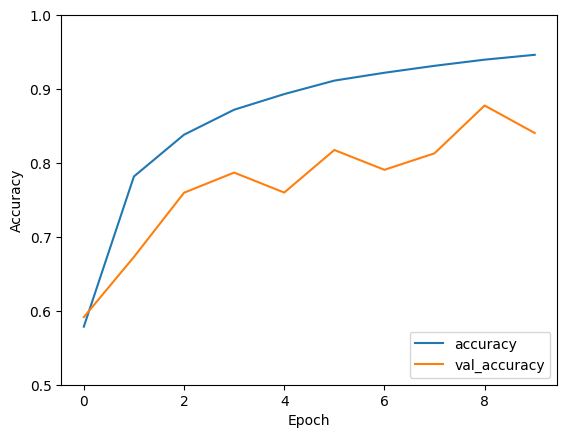

In [20]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

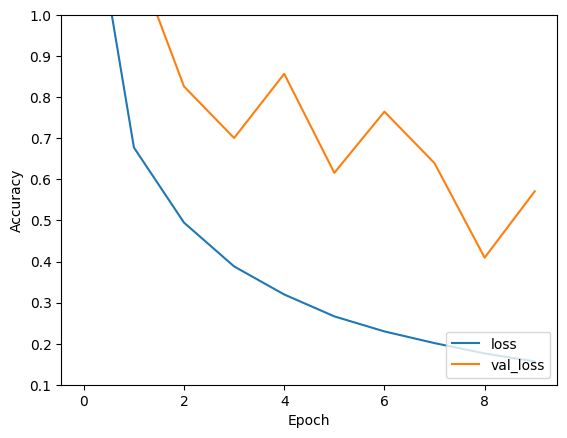

In [22]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')
plt.show()